# Project 3: Real world data
- Explore the data.
- Train at least three different regression models and cross-validate them with MSE and R2-score.
- Try out pre-processing techniques.
- Choose two types of feature selection and implement at least one method for each.
Experimentally evaluate your feature selections.
- For the best performing combination of model and pre-processing steps, implement and plot the so-called learning curve
on your own.

In [195]:
# global imports
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display
import math
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer, Normalizer

## Data exploration

In [196]:
# generic function to extract named properties from the data set items
# fs is a list of tuples, first a name, then a function mapping an item to a property
def property_table(fs, ds):
    keys = list(ds.keys()) # row names
    prop_names = fs.keys() # column names
    funcs = fs.values() # property functions
    items = list(map(lambda t: t[1], ds.items())) # data items
    mapped = zip(*list(map(lambda f: map(f, items), funcs))) # each prop for each item
    df = pd.DataFrame(mapped, index=keys, columns=prop_names) # use pandas.DataFrame to print a table
    display(df)
def plane(X, a, b):
    return list(map(lambda v: [v[a], v[b]], X))
def gauss_sum(n):
    return int((n**2+n)/2)
def plot_plane(X, ax, a, b):
    #min = np.minimum(a,b)
    #b = np.maximum(a,b)
    #a=min
    p=plane(X, a, b)
    ax.scatter(*zip(*p), s=1.0,  c=y)
    ax.set_title(f"Plane ({a}, {b})")
def plot_hyperspace(X):
    dim_count = len(X[0])
    #print(f"dim_count = {dim_count-1}")
    plane_count = gauss_sum(dim_count-1)
    #print(f"{plane_count}")
    grid_width = 7
    grid_height = math.ceil(plane_count/grid_width)
    #print(f"grid_height = {grid_height}")
    plt.close('all')
    width=dim_count
    for a in range(0, width):
        fig, axs = plt.subplots(1, width)
        fig.set_figwidth(width*2)
        fig.set_figheight(2)
        for b in range(0, width):
            #k = b + a*width
            #print(f"k={k} p=({a}, {b})")
            plot_plane(X, axs[b], a, b)
        plt.tight_layout()

,Count,Shape,Min,Max,Mean,Std
X,1460,"(1460, 20)","[1300, 1, 1, 1872, 0, 334, 0, 334, 0, 0, 0, 2,...","[215245, 10, 9, 2010, 6110, 4692, 2065, 5642, ...","[10517.0, 6.0, 6.0, 1971.0, 1057.0, 1163.0, 34...","[9978.0, 1.0, 1.0, 30.0, 439.0, 386.0, 436.0, ..."
y,1460,"(1460, 1)",[34900],[755000],[180921.0],[79415.0]


,Min,Max,Mean,Std
LotArea,1300,215245,10517.0,9978.0
OverallQual,1,10,6.0,1.0
OverallCond,1,9,6.0,1.0
YearBuilt,1872,2010,1971.0,30.0
TotalBsmtSF,0,6110,1057.0,439.0
1stFlrSF,334,4692,1163.0,386.0
2ndFlrSF,0,2065,347.0,436.0
GrLivArea,334,5642,1515.0,525.0
FullBath,0,3,2.0,1.0
HalfBath,0,2,0.0,1.0


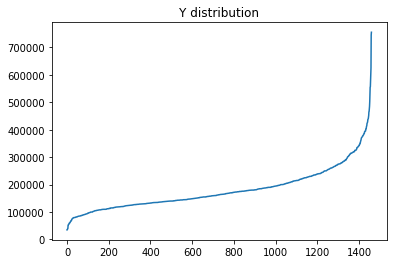

In [197]:
# TODO: load dataset 1
data_set = np.load('dataset.npz')
X = data_set['X']
y = data_set['y']
features = data_set['features']
property_table({
    'Count': lambda item: len(item),
    'Shape': lambda item: item.shape,
    'Min': lambda item: np.round(np.amin(item, axis=0)),
    'Max': lambda item: np.round(np.amax(item, axis=0)),
    'Mean': lambda item: np.round(np.mean(item, axis=0)),
    'Std': lambda item: np.round(np.std(item, axis=0)),
}, {
    "X": X,
    "y": y
})
def feature_info(dict):
    property_table({
        'Min': lambda item: np.round(np.amin(item, axis=0)),
        'Max': lambda item: np.round(np.amax(item, axis=0)),
        'Mean': lambda item: np.round(np.mean(item, axis=0)),
        'Std': lambda item: np.round(np.std(item, axis=0)),
    }, dict)
plt.title("Y distribution")
plt.plot(sorted(y))
feature_dict = { name: np.choose(i, X.T) for (i, name) in enumerate(features)}
feature_info(feature_dict)
#plot_hyperspace(X)

## Training & Evaluation

In [198]:
CROSS_VAL_FOLDS=5
# train and score model using cross validation
def score_model(model, data_pair, scoring):
    (x, y) = data_pair
    return cross_val_score(model, x, y.ravel(), cv=CROSS_VAL_FOLDS, scoring=scoring)
# score a dictionary of models
def score_models(models, data_pair, scoring):
    #print(f'Scoring: {scoring}')
    #print(f'Scoring {name} model')
    return { name: score_model(model, data_pair, scoring) for name, model in models.items() }
# test multiple models on an input
def score_models_on_data(regs, name, data_pair, scorings):
    #print(f'Scoring models on {name} data')
    #print(f'{name} = {X}')
    return { scoring: score_models(regs, data_pair, scoring) for scoring in scorings.keys() }
# test multiple models on multiple data scalings using multiple scorings
def score_all_models_on_all_data_using_all_scorings(regs, data, scorings):
    # data_scores is a 4D dictionary "tensor" containing
    # scoring_scores for each data scaling
    # scoring_scores are 3D dictionaries containing
    # model_scores for each scoring
    # model_scores are 2D dictionaries containing
    # scores for each model
    # scores are 1D arrays of scores with length CROSS_VAL_FOLDS
    data_scores = {
        name: score_models_on_data(regs, name, data_pair, scorings)
        for name, data_pair in data.items()
    }
    for (i, (name, scoring_scores)) in enumerate(data_scores.items()):
        plot_model_scores_for_data(name, scoring_scores)
    plot_avg_model_scores_by_data_scaling(data_scores)
    plot_avg_data_scaling_scores_by_model(data_scores)
# transpose first two levels of dictionary
def sub_keys(d):
    return { key for sub in d.values() for key in sub.keys() }
# transpose first two levels of dictionary
def transpose_dict(d):
    keys = sub_keys(d)
    return {
        key: { k:d[k][key] for k in d if key in d[k] } for key in keys
    }
# plot each scaling's scores averaged across all models
def plot_avg_model_scores_by_data_scaling(data_scores):
    # average scores across models
    avg_data_scores = {
        scaling: {
            scoring: np.mean(np.array(list(model_scores.values())), axis=(0,1))
            for scoring, model_scores in scoring_scores.items()
        } for scaling, scoring_scores in data_scores.items()
    }
    # transpose so that scoring dictionary is top level
    avg_data_scores_transposed = transpose_dict(avg_data_scores)
    #print(avg_data_scores_transposed)
    plot_bar_charts_for_dicts(
        "Average model scores by data scaling",
        "Avg Model score",
        avg_data_scores_transposed
    )
# plot each models scores averaged across all data scalings
def plot_avg_data_scaling_scores_by_model(data_scores):
    transposed = transpose_dict(data_scores)
    transposed_again = {
        scoring: transpose_dict(data_scores) for scoring, data_scores in transposed.items()
    }
    avg_model_scores_transposed = {
        scoring: {
            model: np.mean(np.array(list(data_scores.values())), axis=(0,1))
            for model, data_scores in model_scores.items()
        } for scoring, model_scores in transposed_again.items()
    }
    plot_bar_charts_for_dicts(
        "Average scaling scores by model",
        "Avg Scaling score",
        avg_model_scores_transposed
    )
# plot one titled, labelled bar chart for each nested dictonary in dicts
def plot_bar_charts_for_dicts(title, ylabel, dicts):
    plt.figure(figsize=(20,6))
    plt.suptitle(title)
    n = len(dicts)
    for (i, (name, data)) in enumerate(dicts.items()):
        plt.subplot(1,n,i+1)
        plot_bar_chart(ylabel, name, {k: v for k, v in sorted(data.items(), key=lambda t: t[1])})
def plot_bar_chart(ylabel, name, data, width=0.25):
    # barchart from https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barchart.html
    values = data.values()
    ind = np.arange(len(values))
    low = min(values)
    high = max(values)
    plt.gca().set_ylim([low - 0.5000*(high-low), high + 0.5000*(high-low)])
    plt.gca().bar(ind, values, width)
    plt.gca().set_title(name)
    plt.gca().set_ylabel(ylabel)
    plt.gca().set_xticks(ind)
    plt.gca().set_xticklabels(data.keys(), rotation=45, rotation_mode="anchor", ha="right")
    plt.gcf().tight_layout()
def plot_model_scores_for_data(data_name, scoring_scores):
    plt.figure(figsize=(20,6))
    plt.gcf().suptitle(data_name)
    n = len(scoring_scores)
    for (i, (scoring, model_scores)) in enumerate(scoring_scores.items()):
        plt.subplot(1,n,i+1)
        plt.title(scoring)
        plot_model_scores(model_scores)
def plot_model_scores(scores):
    plt.ylabel("Scores")
    for name, scores in scores.items():
        plot_model_score(name, scores)
    plt.legend()
def plot_model_score(name, scores):
    #print(f"Plotting scores for model {name}")
    #print(f"Scores {scores.shape}")
    avg_score = np.mean(scores)
    c = next(plt.gca()._get_lines.prop_cycler)['color']
    plt.plot(scores, color=c, label=name, alpha=0.7)
    plt.axhline(avg_score, color=c, linestyle="--", label=f"{name}(average)")
def scale(data, scaler):
    return scaler.fit_transform(data)

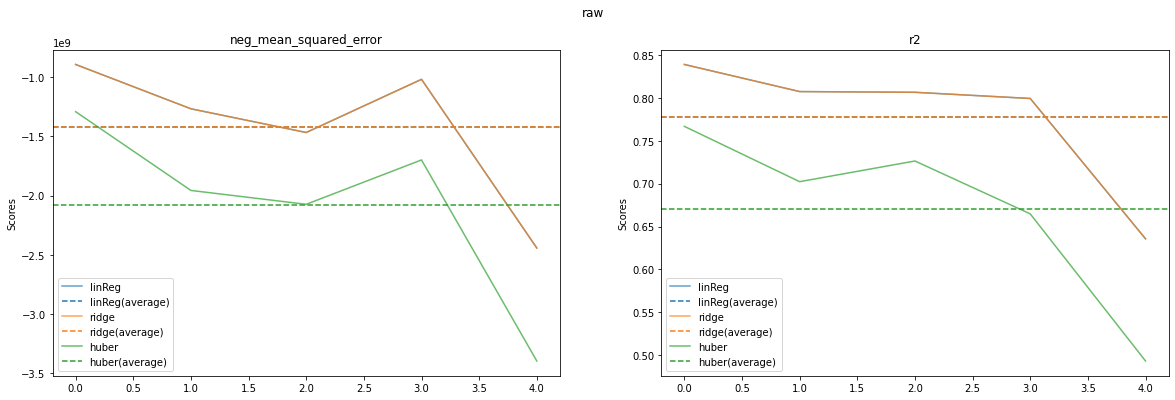

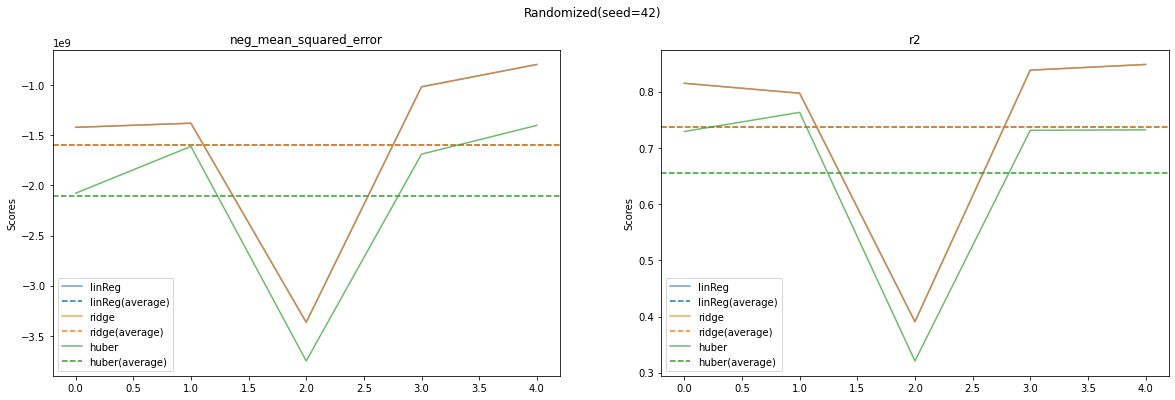

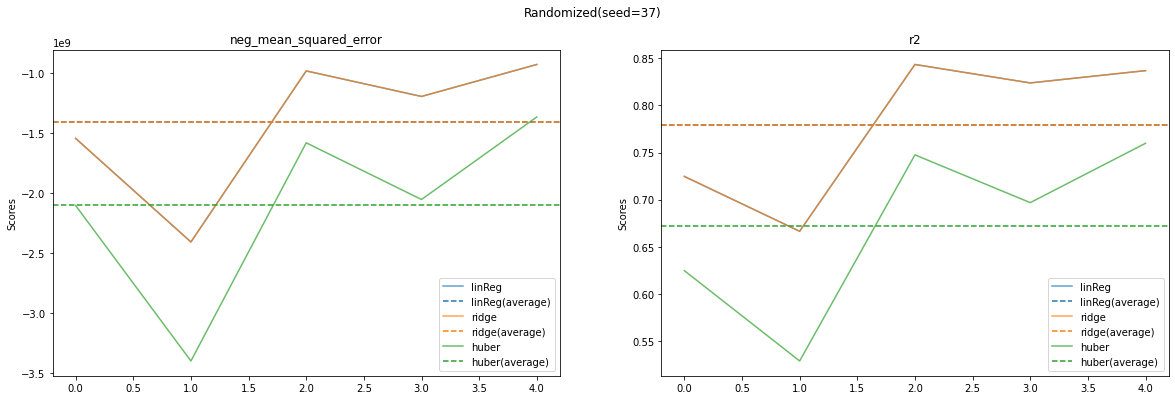

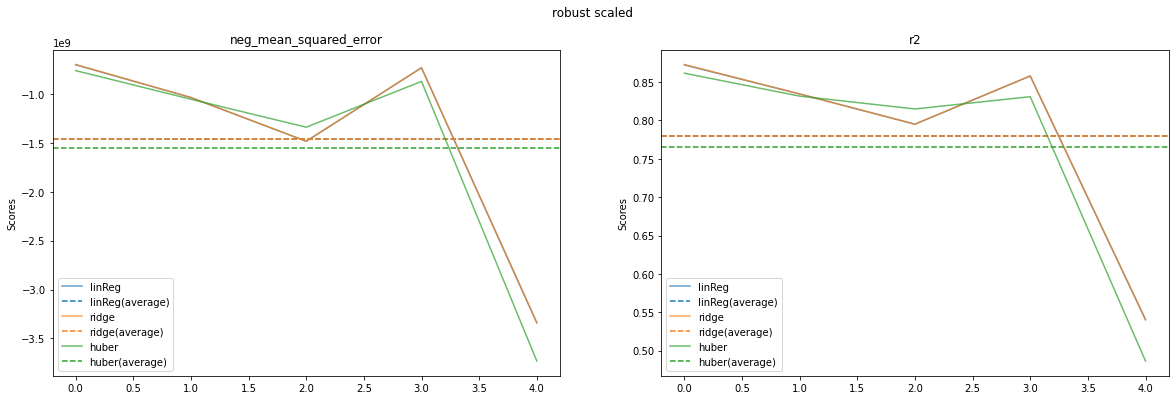

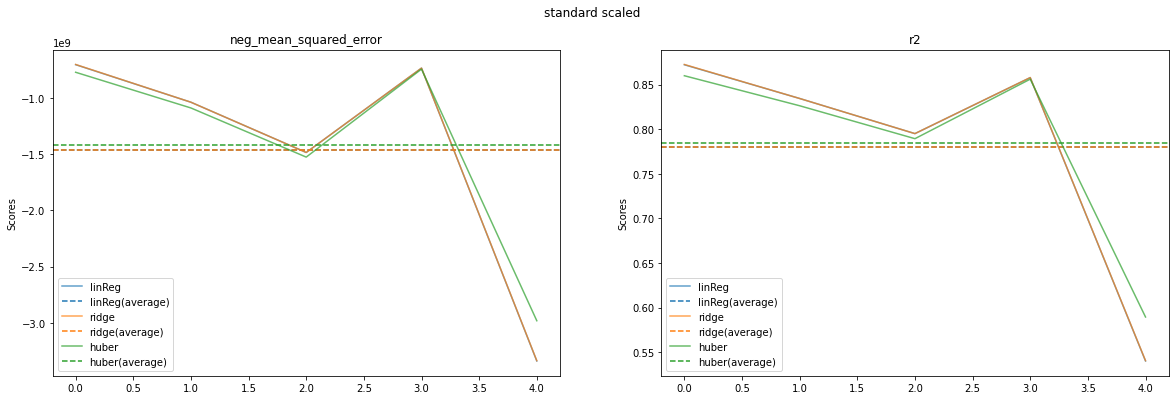

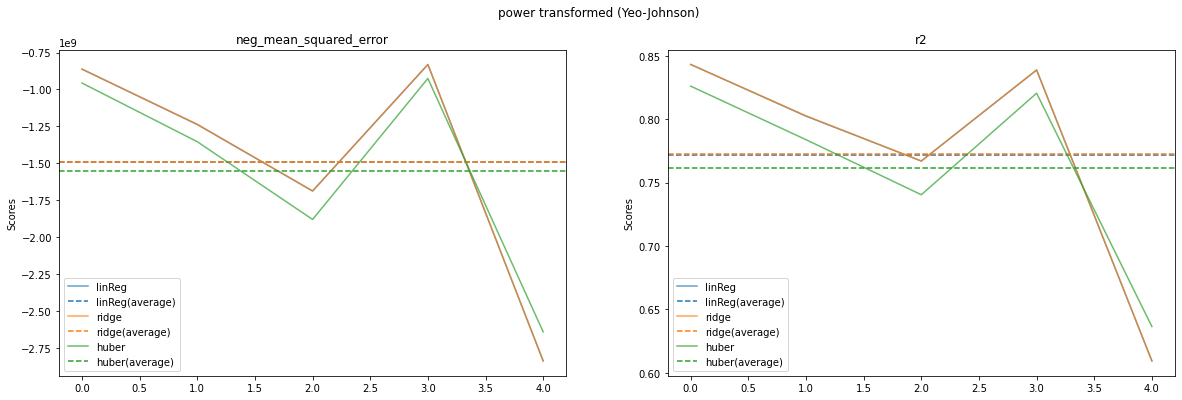

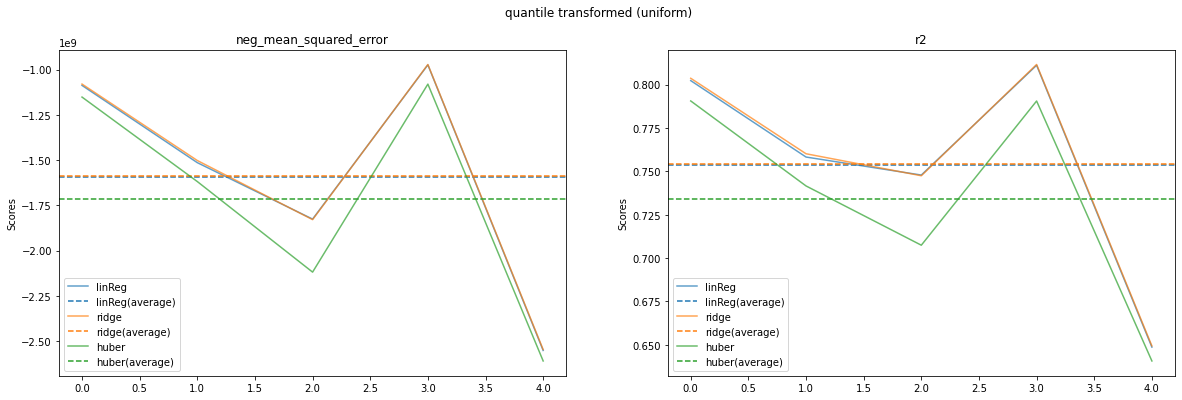

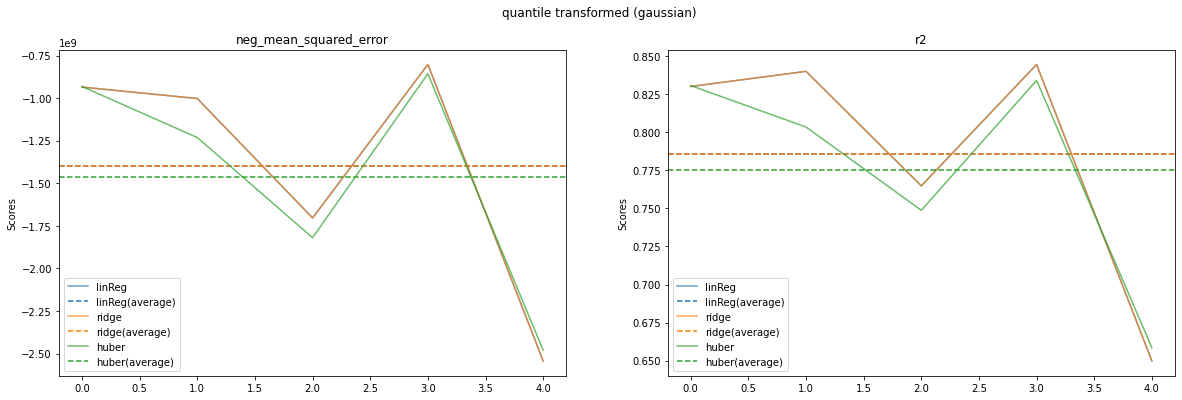

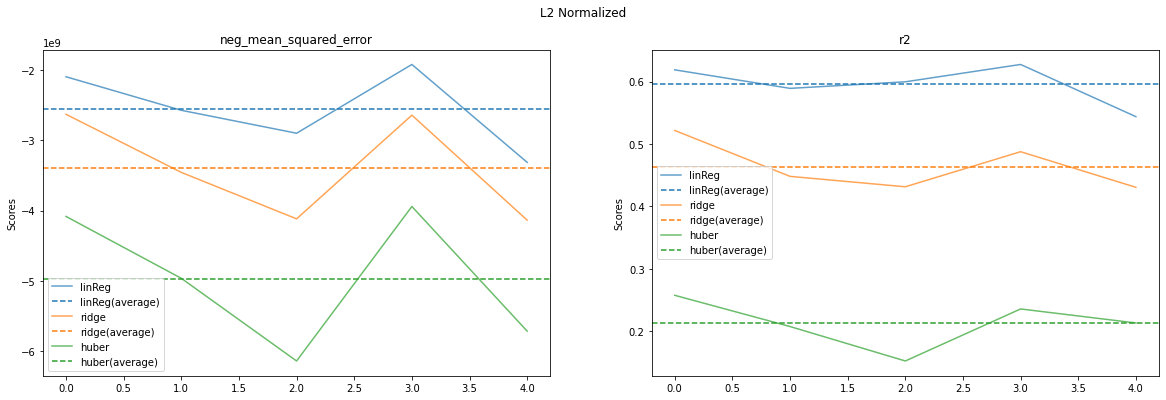

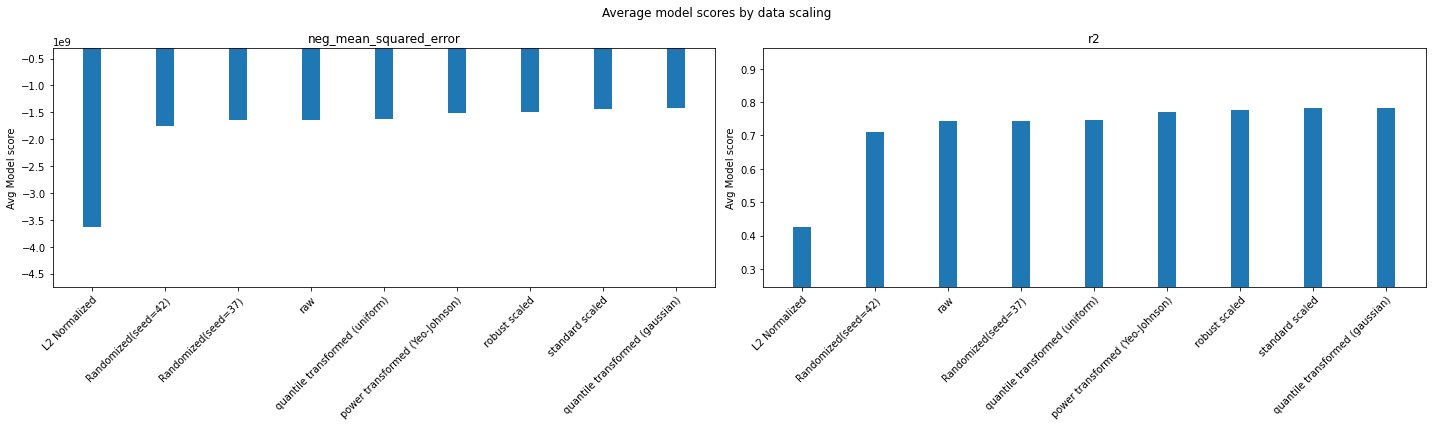

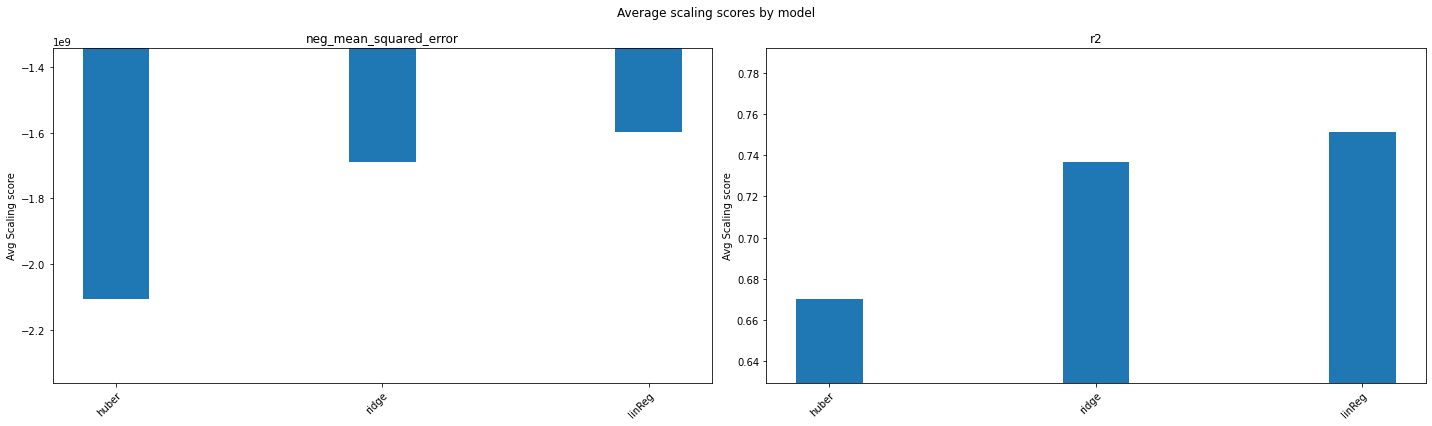

In [199]:
# TODO: train a Logistic Regression, ridge regression and Huber loss regression using cross validation
scorings = {
    "neg_mean_squared_error": lambda y_true, y_pred: -mean_squared_error(y_true, y_pred),
    "r2": r2_score,
}
regs = {
    "linReg": LinearRegression(),
    "ridge": Ridge(),
    "huber": HuberRegressor(),
}
data_raw = (X, y)
# randomize data multiple times
p = np.random.RandomState(seed=42).permutation(len(X))
data_randomized_42 = (X[p], y[p])
p = np.random.RandomState(seed=37).permutation(len(X))
data_randomized_37 = (X[p], y[p])
p = np.random.RandomState(seed=231).permutation(len(X))
(X, y) = (X[p], y[p])
# Some scalers from https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
data = {
    "raw": data_raw,
    "Randomized(seed=42)": data_randomized_42,
    "Randomized(seed=37)": data_randomized_37,
    "robust scaled": (scale(X, RobustScaler()), y),
    "standard scaled": (scale(X, StandardScaler()), y),
    "power transformed (Yeo-Johnson)": (scale(X, PowerTransformer(method='yeo-johnson')), y),
    "quantile transformed (uniform)": (scale(X, QuantileTransformer(output_distribution='uniform')), y),
    "quantile transformed (gaussian)": (scale(X, QuantileTransformer(output_distribution='normal')), y),
    "L2 Normalized": (scale(X, Normalizer()), y),
}
# huber regressor throws warnings even on scaled data
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    score_all_models_on_all_data_using_all_scorings(regs, data, scorings)

/usr/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 907429832957.476, tolerance: 758903729.6660691
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 857003094023.4666, tolerance: 737883890.365574
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 814042827536.7196, tolerance: 706879980.470252
  model = cd_fast.enet_coordinate_descent(
/usr/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might wa

Remaining features: 19 (of 20)


,Min,Max,Mean,Std
LotArea,-1.0,21.0,-0.0,1.0
OverallQual,-4.0,3.0,0.0,1.0
OverallCond,-4.0,3.0,0.0,1.0
YearBuilt,-3.0,1.0,0.0,1.0
TotalBsmtSF,-2.0,12.0,0.0,1.0
1stFlrSF,-2.0,9.0,0.0,1.0
2ndFlrSF,-1.0,4.0,-0.0,1.0
GrLivArea,-2.0,8.0,-0.0,1.0
FullBath,-3.0,3.0,0.0,1.0
BedroomAbvGr,-4.0,6.0,0.0,1.0


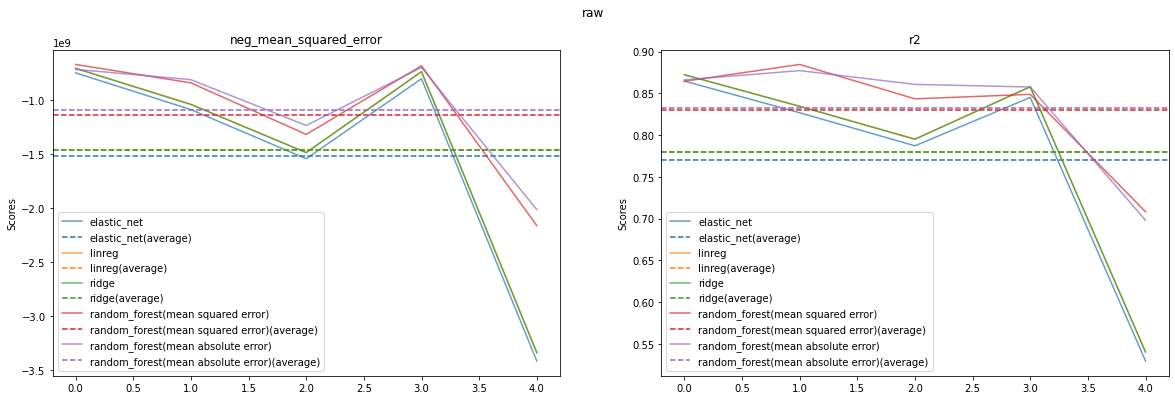

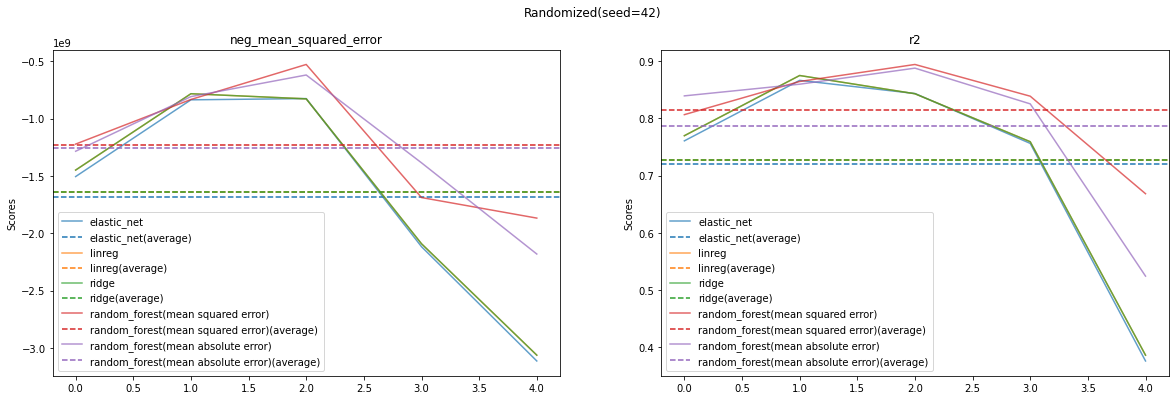

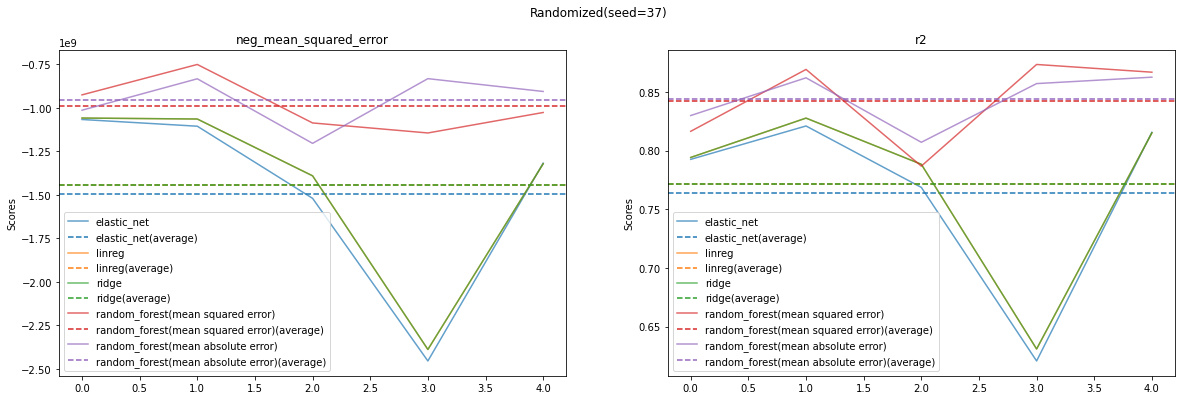

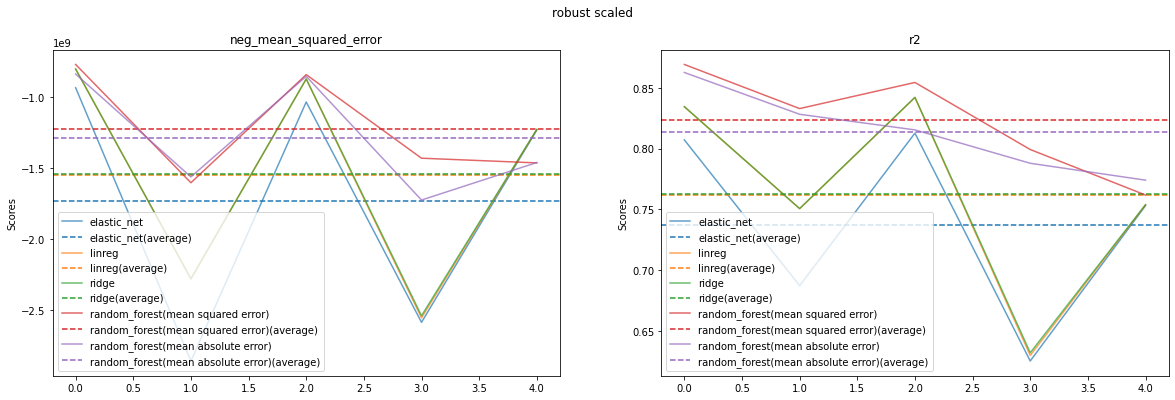

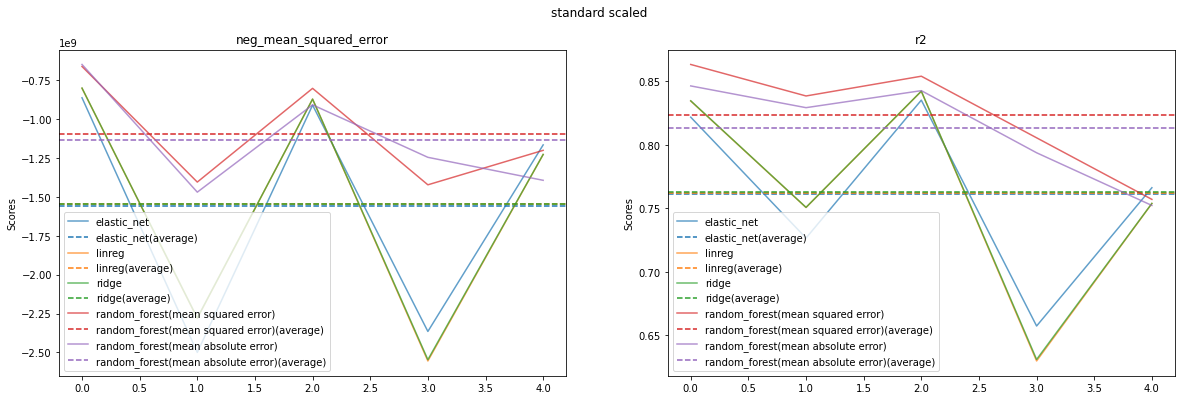

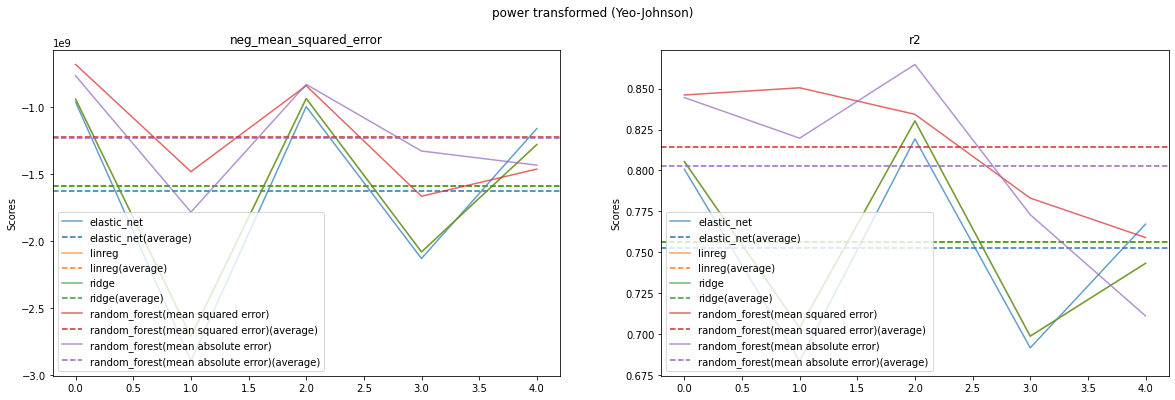

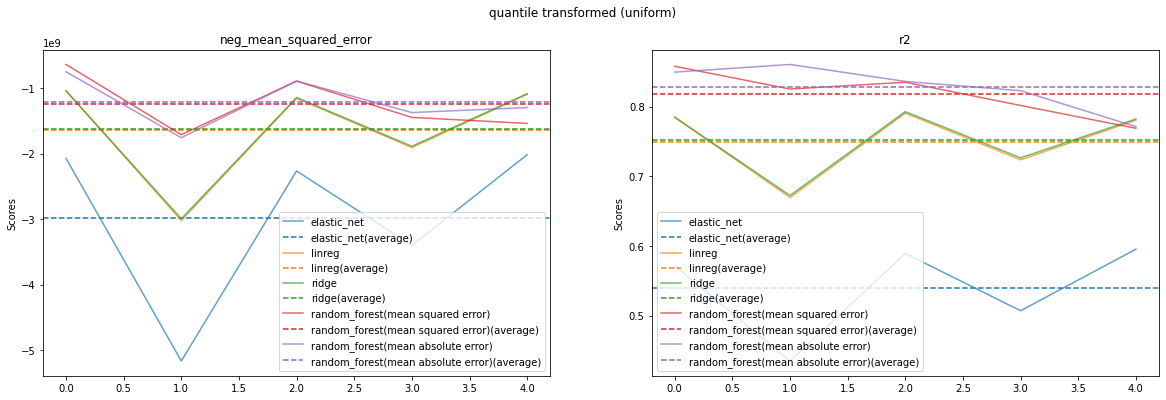

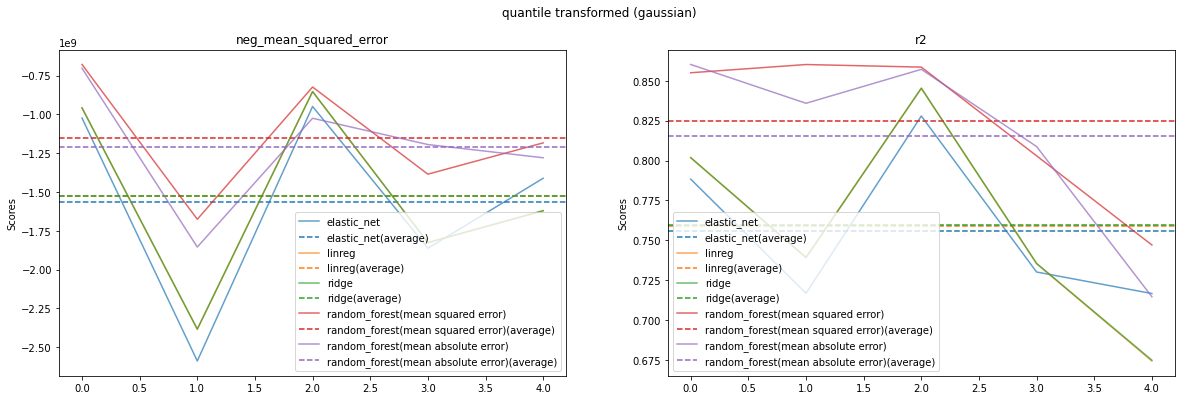

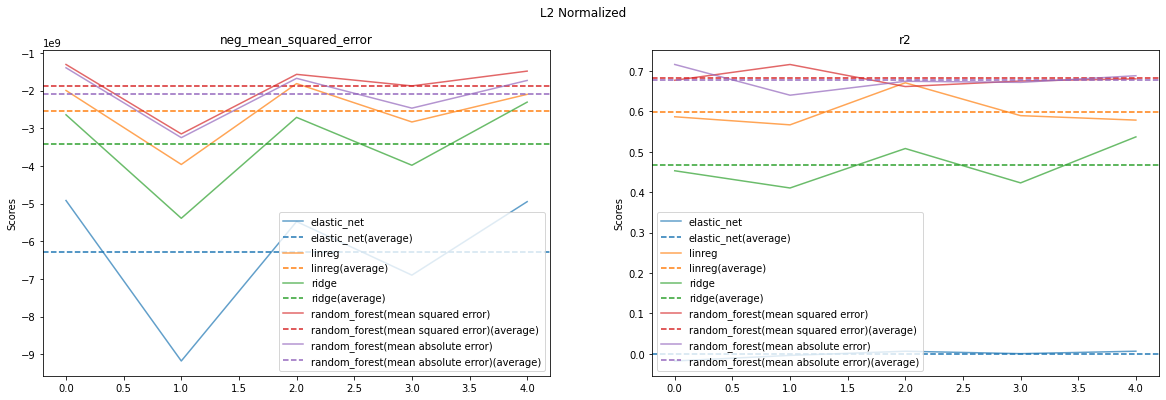

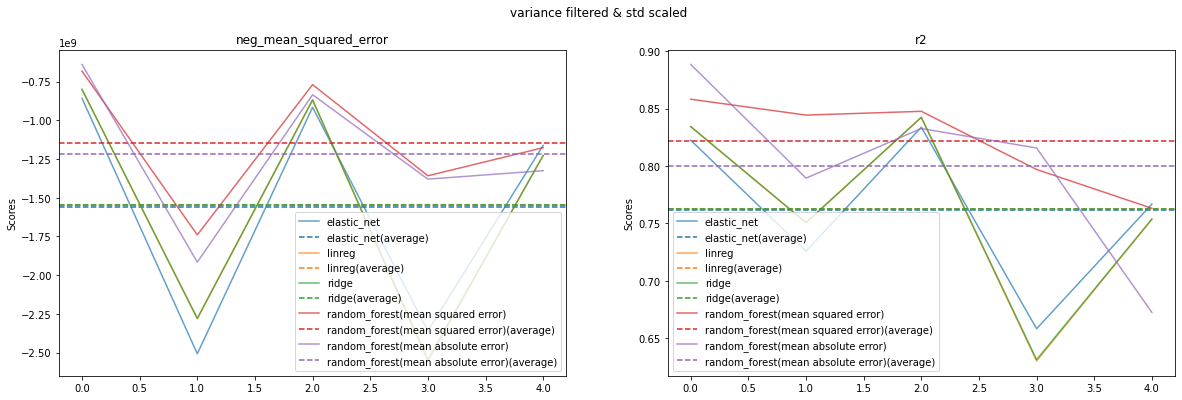

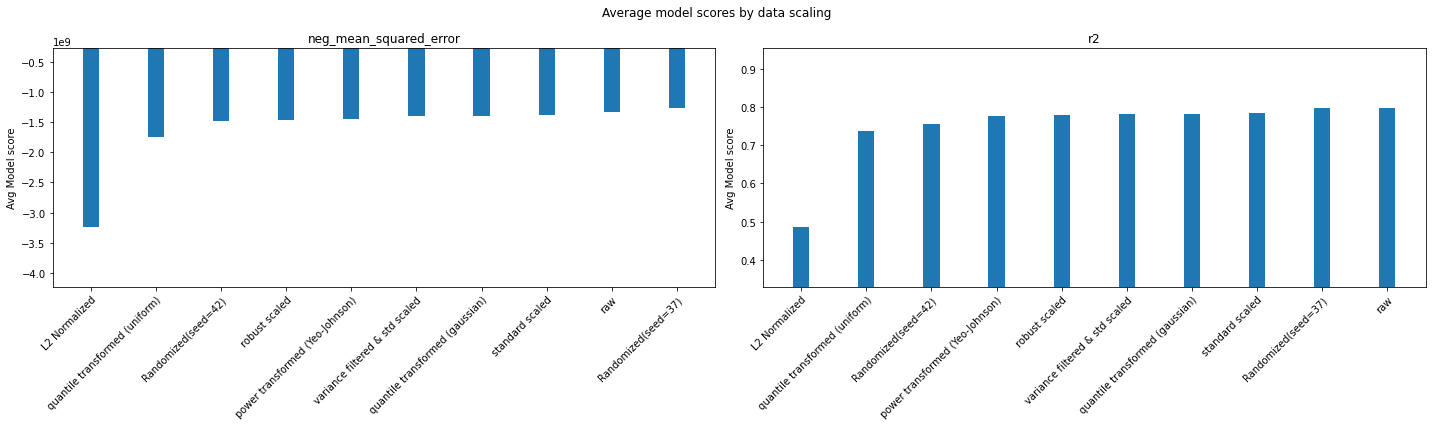

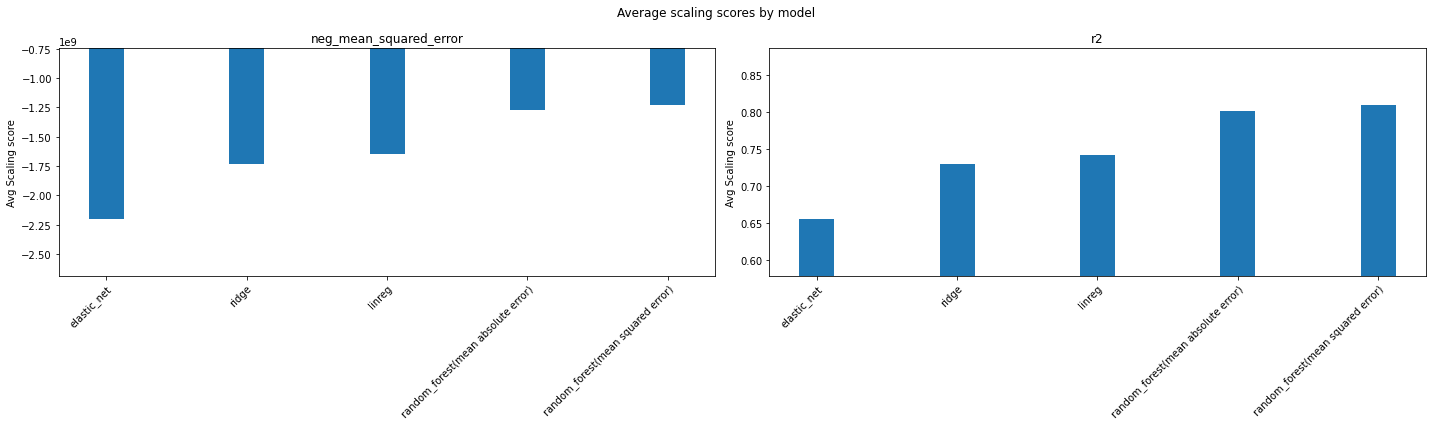

In [200]:
# Todo: evaluate different techniques of feature selection
# embedded feature selections
regs = {
    "elastic_net": ElasticNet(),
    "linreg": LinearRegression(),
    "ridge": Ridge(),
    "random_forest(mean squared error)": RandomForestRegressor(n_estimators=10),
    "random_forest(mean absolute error)": RandomForestRegressor(n_estimators=10, criterion="mae"),
}
# filter feature selections
data_raw = (X, y)
# randomize data multiple times
p = np.random.RandomState(seed=42).permutation(len(X))
data_randomized_42 = (X[p], y[p])
p = np.random.RandomState(seed=37).permutation(len(X))
data_randomized_37 = (X[p], y[p])
p = np.random.RandomState(seed=231).permutation(len(X))
(X, y) = (X[p], y[p])
std_scaled_data = (scale(X, StandardScaler()), y)
var_filter = VarianceThreshold(threshold=0.3)
var_filtered_data = (scale(var_filter.fit_transform(X), StandardScaler()), y)
data = {
    "raw": data_raw,
    "Randomized(seed=42)": data_randomized_42,
    "Randomized(seed=37)": data_randomized_37,
    "robust scaled": (scale(X, RobustScaler()), y),
    "standard scaled": std_scaled_data,
    "power transformed (Yeo-Johnson)": (scale(X, PowerTransformer(method='yeo-johnson')), y),
    "quantile transformed (uniform)": (scale(X, QuantileTransformer(output_distribution='uniform')), y),
    "quantile transformed (gaussian)": (scale(X, QuantileTransformer(output_distribution='normal')), y),
    "L2 Normalized": (scale(X, Normalizer()), y),
    "variance filtered & std scaled": var_filtered_data,
}
score_all_models_on_all_data_using_all_scorings(regs, data, scorings)
remaining_features = features[var_filter.get_support()]
print(f"Remaining features: {len(remaining_features)} (of {len(features)})")
feature_dict = { name: np.choose(i, var_filtered_data[0].T) for (i, name) in enumerate(remaining_features)}
feature_info(feature_dict)

## Learning curves

In [201]:
# learning curve for model, data and scoring
def learning_curve_scores(model, x_train, y_train, x_test, y_test, score_fn, step):
    train_scores = []
    test_scores = []
    n = len(x_train)
    steps = math.floor(n/step)
    for i in range(1, steps+1):
        l = min(i*step, n)
        model.fit(x_train[0:l], y_train[0:l].ravel())
        y_pred_train = model.predict(x_train[0:l])
        y_pred_test = model.predict(x_test[0:l])
        train_scores.append(score_fn(y_train[0:l], y_pred_train))
        test_scores.append(score_fn(y_test[0:l], y_pred_test))
    return np.array(train_scores), np.array(test_scores)
# calc average cross validated learning curve for model, data and scoring
def cv_learning_curve_scores(model, data, score_fn, step):
    (x_data, y_data) = data
    all_train_scores = []
    all_test_scores = []
    for (i, (train_index, test_index)) in enumerate(KFold(n_splits=CROSS_VAL_FOLDS).split(x_data)):
        x_train, x_test = x_data[train_index], x_data[test_index]
        y_train, y_test = y_data[train_index], y_data[test_index]
        train_scores, test_scores = learning_curve_scores(model, x_train, y_train, x_test, y_test, score_fn, step)
        all_train_scores.append(train_scores)
        all_test_scores.append(test_scores)
    avg_train_scores = np.mean(all_train_scores, axis=0)
    avg_test_scores = np.mean(all_test_scores, axis=0)
    return (avg_train_scores, avg_test_scores)
# plot average learning curves for each model with all data scalings and scorings
def plot_all_learning_curves(regs, datas, scorings, step=1):
    data_count = len(datas)
    scoring_count = len(scorings)
    for (model_name, model) in regs.items():
        fig, ax = plt.subplots(data_count, scoring_count, figsize=(10*scoring_count,4*data_count))
        fig.suptitle(f"Average Learning curves (step={step}) for Model: {model_name}")
        for (i, (data_name, data)) in enumerate(datas.items()):
            ax[i,0].annotate(f"Scaling: {data_name}",
                             xy=(0, 0.5),
                             xytext=(-ax[i,0].yaxis.labelpad, 0),
                             xycoords=ax[i,0].yaxis.label,
                             textcoords='offset points',
                             size='large',
                             ha='right',
                             va='center'
                             )
            for (j, (scoring_name, scoring)) in enumerate(scorings.items()):
                ax[0, j].set_title(f"Score: {scoring_name}")
                avg_train_scores, avg_test_scores = cv_learning_curve_scores(model, data, scoring, step)
                ax[i, j].plot(avg_train_scores, label='train score')
                ax[i, j].plot(avg_test_scores, label='test score')
                ax[i, j].set_xlabel("steps")
                ax[i, j].set_ylabel("score")
                ax[i, j].legend()
        fig.tight_layout()
        fig.subplots_adjust(left=0.15, top=0.9)
        plt.show()

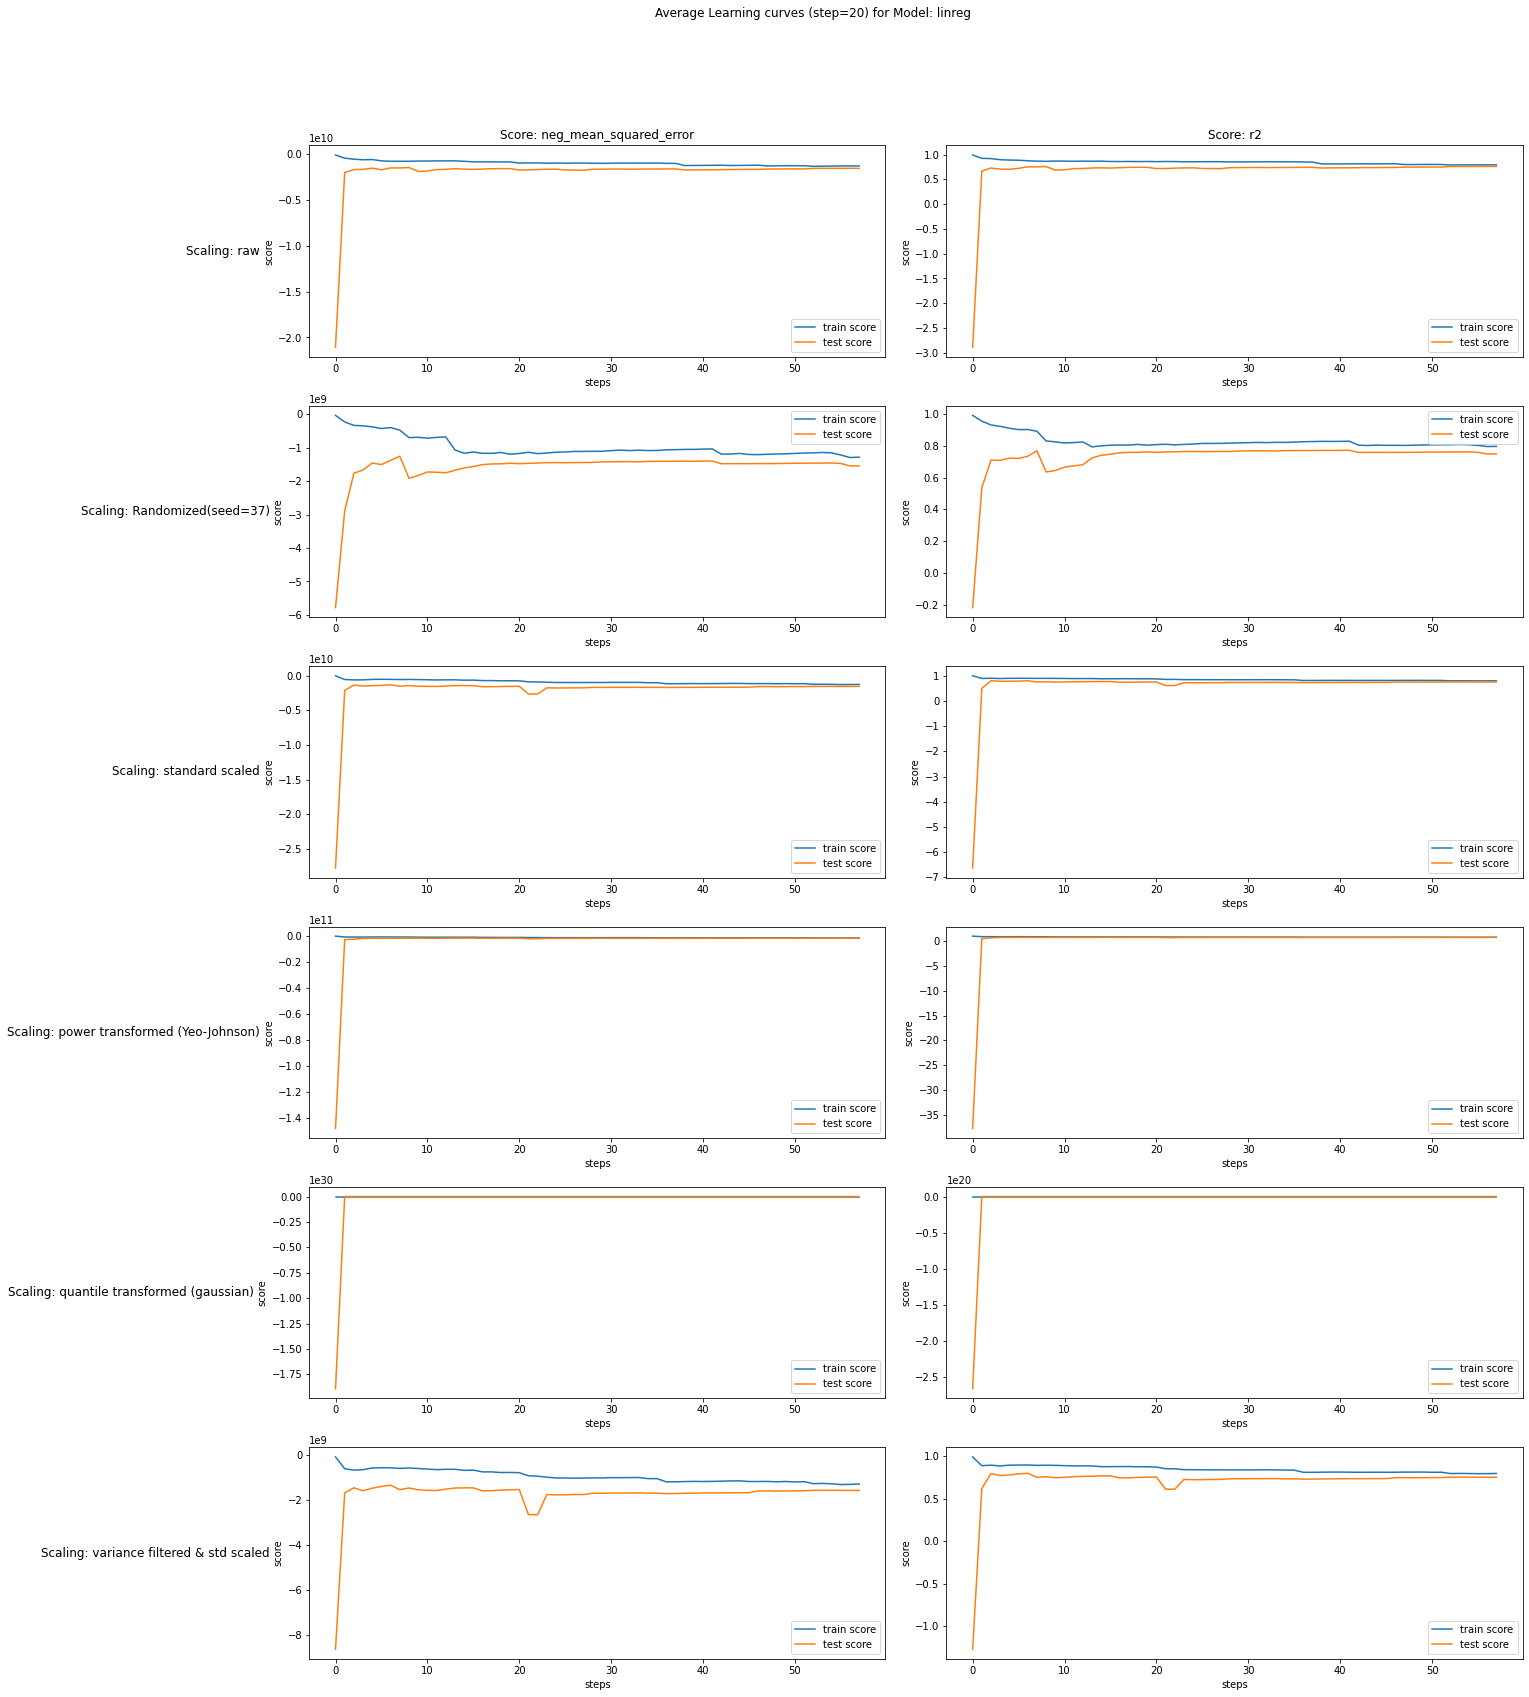

In [ ]:
scorings = {
    "neg_mean_squared_error": lambda y_true, y_pred: -mean_squared_error(y_true, y_pred),
    "r2": r2_score,
}
regs = {
    "linreg": LinearRegression(),
    "random_forest(mean squared error)": RandomForestRegressor(n_estimators=10),
    "random_forest(mean absolute error)": RandomForestRegressor(n_estimators=10, criterion="mae"),
}
data_raw = (X, y)
# randomize data multiple times
p = np.random.RandomState(seed=42).permutation(len(X))
data_randomized_42 = (X[p], y[p])
p = np.random.RandomState(seed=37).permutation(len(X))
data_randomized_37 = (X[p], y[p])
p = np.random.RandomState(seed=231).permutation(len(X))
(X, y) = (X[p], y[p])
# Some scalers from https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
var_filter = VarianceThreshold(threshold=0.3)
var_filtered_data = (scale(var_filter.fit_transform(X), StandardScaler()), y)
data = {
    "raw": data_raw,
    "Randomized(seed=37)": data_randomized_37,
    "standard scaled": (scale(X, StandardScaler()), y),
    "power transformed (Yeo-Johnson)": (scale(X, PowerTransformer(method='yeo-johnson')), y),
    "quantile transformed (gaussian)": (scale(X, QuantileTransformer(output_distribution='normal')), y),
    "variance filtered & std scaled": var_filtered_data,
}
plot_all_learning_curves(regs, data, scorings, step=20)